# Flood Detection Model Training
This notebook trains ResNet50, DenseNet121, EfficientNetB0, and ViT for flood detection using Sentinel-1 and Sentinel-2 imagery. It includes data preprocessing, model training, evaluation, ensemble methods, and logging with Weights & Biases (W&B).

In [1]:
# Cell 1: Install and import libraries
!pip install rasterio timm wandb --quiet

import os
import glob
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
import timm
import rasterio
from PIL import Image
from torch.amp import autocast, GradScaler
import wandb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from transformers import ViTForImageClassification
import cv2
from collections import Counter

# Set device and random seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
print("Device:", device)

# Create models directory
os.makedirs("models", exist_ok=True)

/home/nhotin/anaconda3/envs/as/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


Total TIFF files found: 36052
Sample file paths:
/home/nhotin/tinltn/dat301m/as/sen12floods/data/sen12floods1/0095/S2_2019-02-06_B05.tif
/home/nhotin/tinltn/dat301m/as/sen12floods/data/sen12floods1/0095/S1B_IW_GRDH_1SDV_20190209T181740_20190209T181805_014873_01BC28_D12A_corrected_VV.tif
/home/nhotin/tinltn/dat301m/as/sen12floods/data/sen12floods1/0095/S2_2019-02-11_B04.tif
/home/nhotin/tinltn/dat301m/as/sen12floods/data/sen12floods1/0095/S1B_IW_GRDH_1SDV_20181223T181742_20181223T181807_014173_01A569_9A1D_corrected_VH.tif
/home/nhotin/tinltn/dat301m/as/sen12floods/data/sen12floods1/0095/S2_2019-01-02_B01.tif


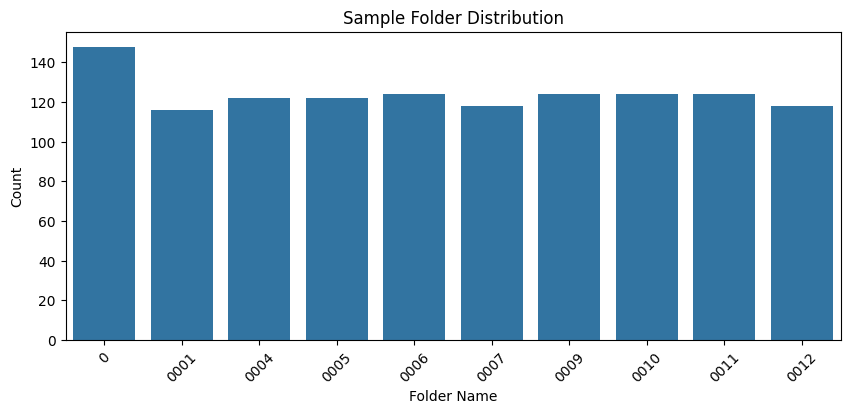

In [2]:
# Cell 2: Load and explore dataset
data_dir = "/home/nhotin/tinltn/dat301m/as/sen12floods/data/sen12floods1"
tif_files = glob.glob(os.path.join(data_dir, "**/*.tif"), recursive=True)
print(f"Total TIFF files found: {len(tif_files)}")

# Print sample file paths
print("Sample file paths:")
for f in tif_files[:5]: print(f)

# Plot folder distribution
folder_names = [os.path.basename(os.path.dirname(file)) for file in tif_files]
folder_counts = Counter(folder_names)
df_folder_counts = pd.DataFrame(list(folder_counts.items()), columns=["Folder", "Count"]).sort_values("Folder").head(10)
plt.figure(figsize=(10, 4))
sns.barplot(data=df_folder_counts, x="Folder", y="Count")
plt.title("Sample Folder Distribution"); plt.xlabel("Folder Name"); plt.ylabel("Count")
plt.xticks(rotation=45); plt.show()

In [3]:
# Cell 3: Load JSON metadata and create label mapping
s1_json_path = os.path.join(data_dir, "S1list.json")
s2_json_path = os.path.join(data_dir, "S2list.json")

with open(s1_json_path, "r") as f: s1_data = json.load(f)
with open(s2_json_path, "r") as f: s2_data = json.load(f)

flood_labels = {}
for folder, details in s1_data.items():
    flood_status = any(entry.get("FLOODING", False) for key, entry in details.items() if isinstance(entry, dict) and "FLOODING" in entry)
    flood_labels[folder] = int(flood_status)
for folder, details in s2_data.items():
    flood_status = any(entry.get("FLOODING", False) for key, entry in details.items() if isinstance(entry, dict) and "FLOODING" in entry)
    flood_labels[folder] = int(flood_status)

print("Flood Label Mapping (Sample):")
for folder, label in list(flood_labels.items())[:10]: print(f"Folder: {folder}, Flooding: {label}")

dataset_folder_names = [os.path.basename(os.path.dirname(file)) for file in tif_files]
mapped_labels = [flood_labels.get(folder, 0) for folder in dataset_folder_names]
print("Label Distribution in Dataset:", Counter(mapped_labels))

Flood Label Mapping (Sample):
Folder: 0063, Flooding: 0
Folder: 0200, Flooding: 1
Folder: 0004, Flooding: 0
Folder: 0307, Flooding: 1
Folder: 0167, Flooding: 1
Folder: 0205, Flooding: 1
Folder: 0166, Flooding: 1
Folder: 0240, Flooding: 1
Folder: 0123, Flooding: 0
Folder: 61, Flooding: 1
Label Distribution in Dataset: Counter({1: 24333, 0: 11719})


Sensor distribution:
 sensor
Sentinel-2    26844
Sentinel-1     9208
Name: count, dtype: int64


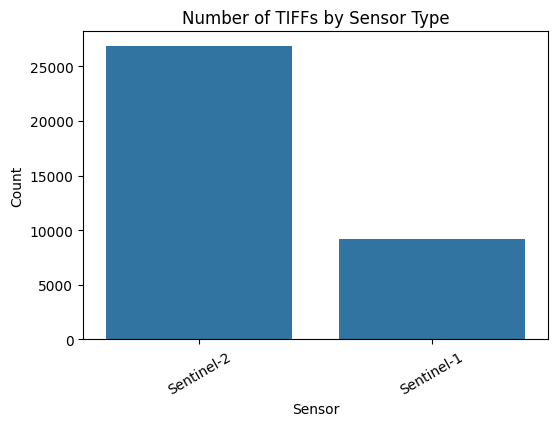

In [4]:
# Cell 4: Classify TIFF files by sensor type
sensor_types = []
for path in tif_files:
    fname = os.path.basename(path)
    if "/S1" in path or fname.startswith("S1"): sensor_types.append("Sentinel-1")
    elif "/S2" in path or fname.startswith("S2"): sensor_types.append("Sentinel-2")
    else: sensor_types.append("Other")

df_sensors = pd.DataFrame({"path": tif_files, "sensor": sensor_types})
counts = df_sensors["sensor"].value_counts()
print("Sensor distribution:\n", counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=counts.index, y=counts.values)
plt.title("Number of TIFFs by Sensor Type"); plt.ylabel("Count"); plt.xlabel("Sensor")
plt.xticks(rotation=30); plt.show()

In [5]:
# Cell 5: Split TIFF files by sensor
sensor_classification = []
for path in tif_files:
    if "/S1" in path or os.path.basename(path).startswith("S1"): sensor_classification.append("Sentinel-1")
    elif "/S2" in path or os.path.basename(path).startswith("S2"): sensor_classification.append("Sentinel-2")
    else: sensor_classification.append("Other")

df_sensors = pd.DataFrame({"filepath": tif_files, "sensor": sensor_classification})
sentinel1_files = df_sensors[df_sensors.sensor == "Sentinel-1"]["filepath"].tolist()
sentinel2_files = df_sensors[df_sensors.sensor == "Sentinel-2"]["filepath"].tolist()
other_files = df_sensors[df_sensors.sensor == "Other"]["filepath"].tolist()
print(f"Sentinel-1 count: {len(sentinel1_files)}\nSentinel-2 count: {len(sentinel2_files)}\nOther count: {len(other_files)}")

Sentinel-1 count: 9208
Sentinel-2 count: 26844
Other count: 0


In [6]:
# Cell 6: Sample Sentinel-1 and Sentinel-2 images
s1_flooded = [fp for fp in sentinel1_files if flood_labels.get(os.path.basename(os.path.dirname(fp)), 0) == 1]
s1_non = [fp for fp in sentinel1_files if flood_labels.get(os.path.basename(os.path.dirname(fp)), 0) == 0]
n = 5
s1_flooded_samples = random.sample(s1_flooded, min(len(s1_flooded), n))
s1_non_samples = random.sample(s1_non, min(len(s1_non), n))
print(f"Sentinel-1: sampled {len(s1_flooded_samples)} flooded, {len(s1_non_samples)} non-flooded images")

s2_b04 = [fp for fp in sentinel2_files if fp.endswith("_B04.tif")]
s2_b04_flooded = [fp for fp in s2_b04 if flood_labels.get(os.path.basename(os.path.dirname(fp)), 0) == 1]
s2_b04_non = [fp for fp in s2_b04 if flood_labels.get(os.path.basename(os.path.dirname(fp)), 0) == 0]
s2_b04_flooded_samples = random.sample(s2_b04_flooded, min(len(s2_b04_flooded), n))
s2_b04_non_samples = random.sample(s2_b04_non, min(len(s2_b04_non), n))
print(f"Sentinel-2: sampled {len(s2_b04_flooded_samples)} flooded, {len(s2_b04_non_samples)} non-flooded B04 files")

Sentinel-1: sampled 5 flooded, 5 non-flooded images
Sentinel-2: sampled 5 flooded, 5 non-flooded B04 files


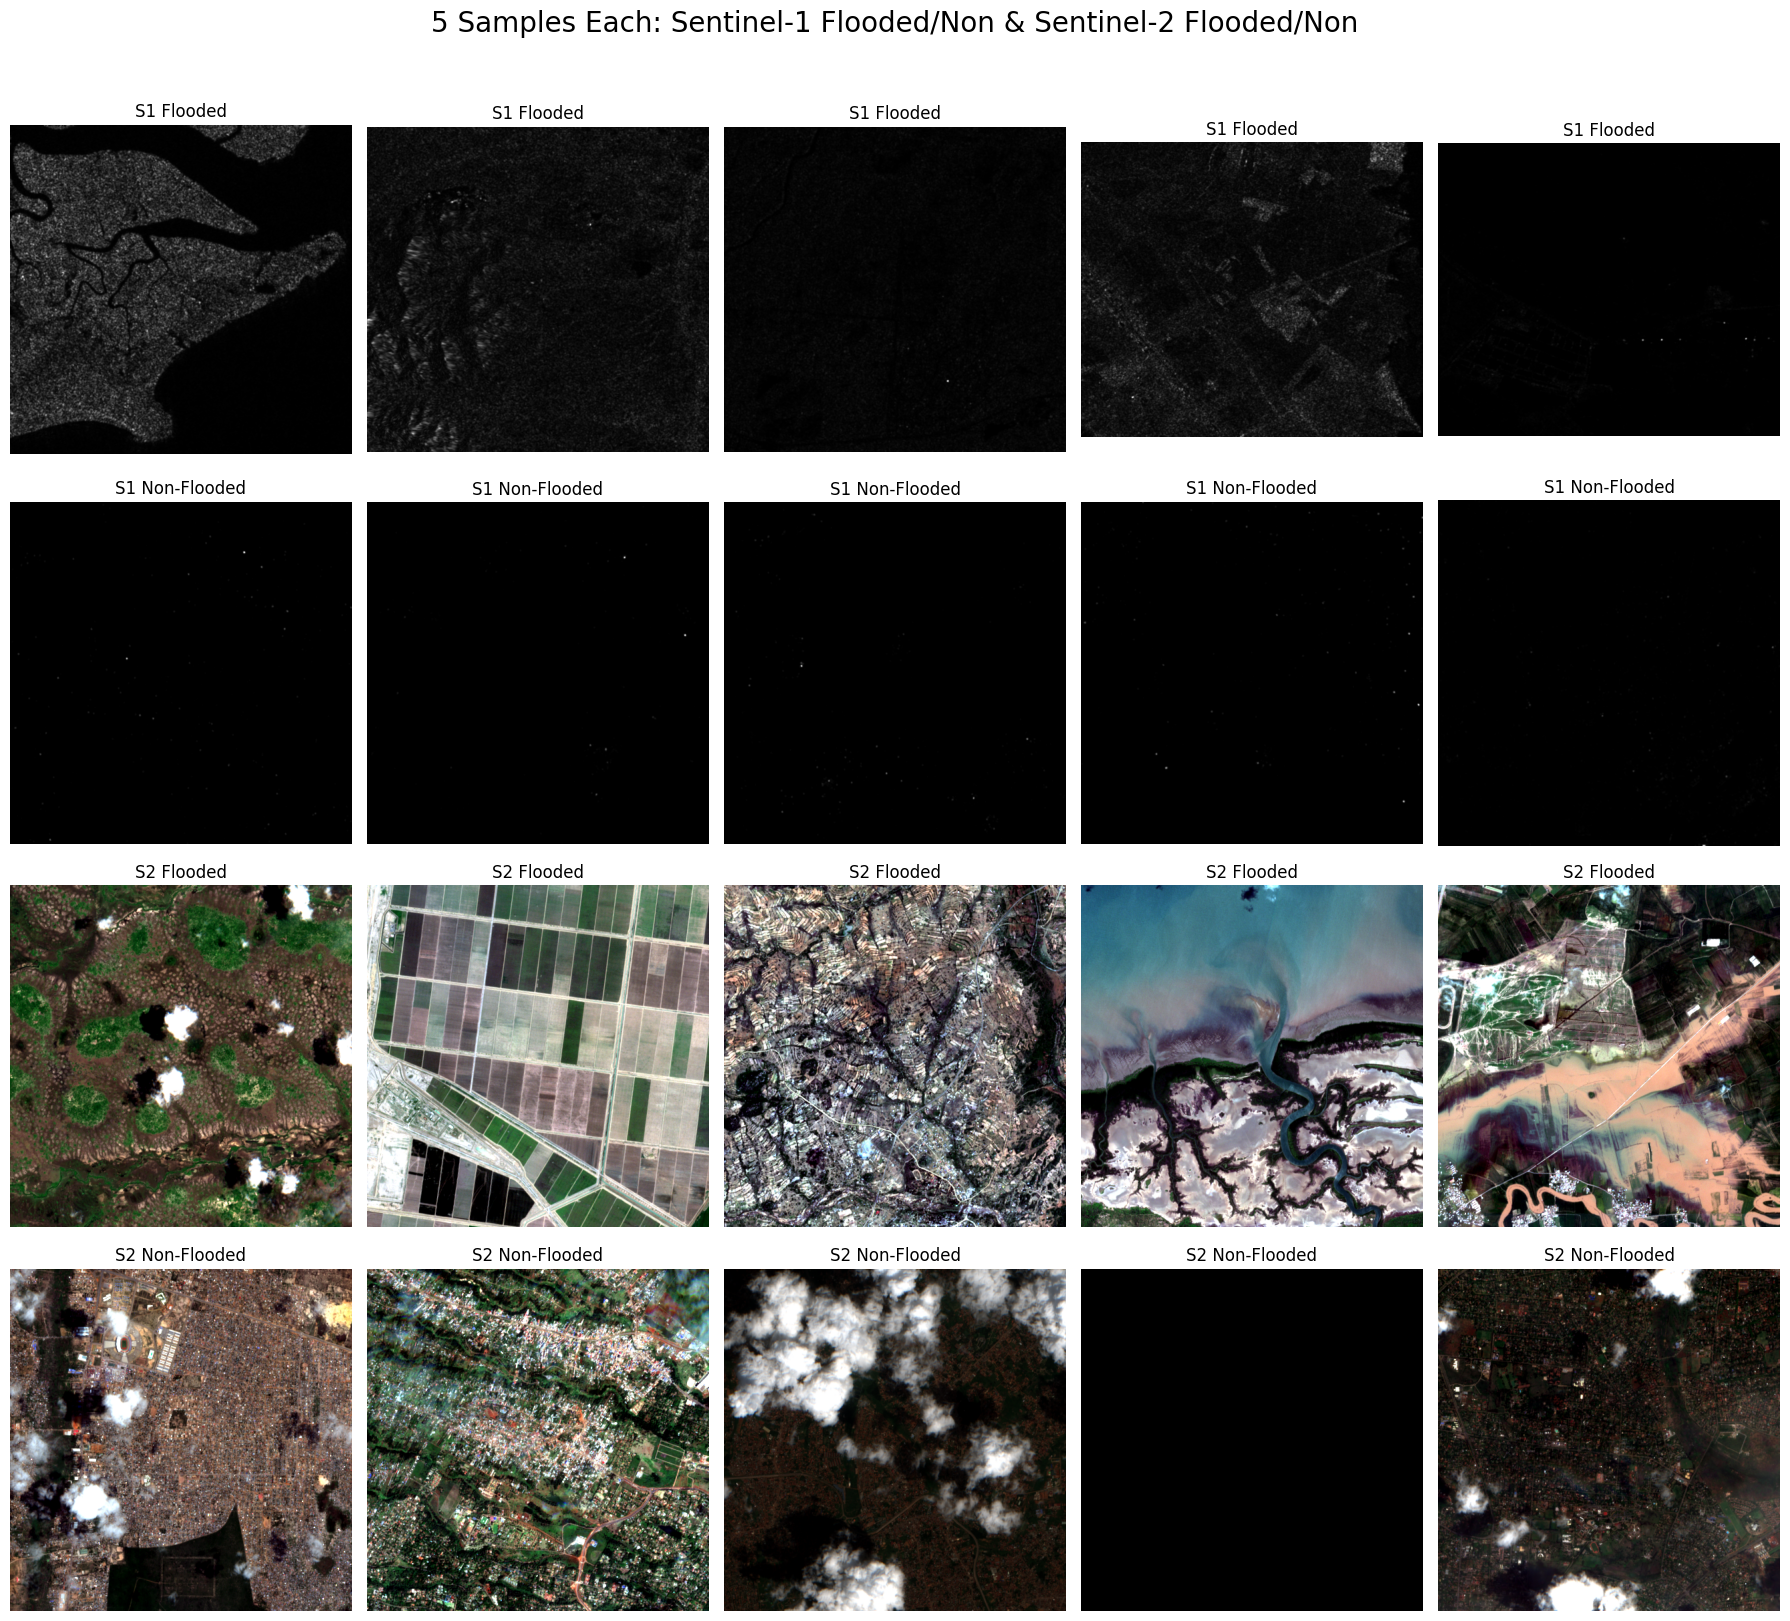

In [7]:
# Cell 7: Visualize sample images
def load_s1_gray(fp):
    with rasterio.open(fp) as src:
        arr = src.read(1).astype(float)
    lo, hi = np.nanmin(arr), np.nanmax(arr)
    arr = (arr - lo) / (hi - lo) if hi > lo else np.zeros_like(arr)
    return (arr * 255).astype(np.uint8)

def load_s2_true_color(b04_fp):
    base = b04_fp[:-8]
    fR, fG, fB = b04_fp, base + "_B03.tif", base + "_B02.tif"
    with rasterio.open(fR) as r, rasterio.open(fG) as g, rasterio.open(fB) as b:
        R, G, B = r.read(1).astype(float), g.read(1).astype(float), b.read(1).astype(float)
    out = np.stack([R, G, B], axis=-1)
    for i in range(3):
        ch = out[..., i]
        lo, hi = np.nanpercentile(ch, (2, 98))
        ch = np.clip(ch, lo, hi)
        out[..., i] = (ch - lo) / (hi - lo) if hi > lo else np.zeros_like(ch)
    return (out * 255).astype(np.uint8)

fig, axes = plt.subplots(4, 5, figsize=(18, 16))
for i, fp in enumerate(s1_flooded_samples):
    axes[0, i].imshow(load_s1_gray(fp), cmap="gray"); axes[0, i].set_title("S1 Flooded"); axes[0, i].axis("off")
for i, fp in enumerate(s1_non_samples):
    axes[1, i].imshow(load_s1_gray(fp), cmap="gray"); axes[1, i].set_title("S1 Non-Flooded"); axes[1, i].axis("off")
for i, fp in enumerate(s2_b04_flooded_samples):
    axes[2, i].imshow(load_s2_true_color(fp)); axes[2, i].set_title("S2 Flooded"); axes[2, i].axis("off")
for i, fp in enumerate(s2_b04_non_samples):
    axes[3, i].imshow(load_s2_true_color(fp)); axes[3, i].set_title("S2 Non-Flooded"); axes[3, i].axis("off")
plt.suptitle("5 Samples Each: Sentinel-1 Flooded/Non & Sentinel-2 Flooded/Non", fontsize=20, y=1.02)
plt.tight_layout(); plt.show()

In [8]:
# Cell 8: Define preprocessing functions
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])])

def preprocess_image(image_path):
    try:
        with rasterio.open(image_path) as src:
            cnt = src.count
            if "/S1" in image_path or os.path.basename(image_path).startswith("S1"):
                arr = src.read(1).astype(float)
                norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
                clean = cv2.medianBlur(norm, 5)
                rgb = np.stack([clean]*3, axis=-1)
            elif "/S2" in image_path or os.path.basename(image_path).startswith("S2") and cnt >= 3:
                r = src.read(4).astype(float) if cnt >= 4 else src.read(1).astype(float)
                g = src.read(3).astype(float) if cnt >= 3 else src.read(1).astype(float)
                b = src.read(2).astype(float) if cnt >= 3 else src.read(1).astype(float)
                for band in [r, g, b]:
                    lo, hi = np.nanpercentile(band, (2, 98))
                    band = np.clip(band, lo, hi)
                    band = (band - lo) / (hi - lo) * 255 if hi > lo else np.zeros_like(band)
                rgb = np.stack([r, g, b], axis=-1).astype(np.uint8)
            else:
                arr = src.read(1).astype(float)
                lo, hi = np.nanmin(arr), np.nanmax(arr)
                arr = ((arr - lo)/(hi - lo) * 255).astype(np.uint8) if hi > lo else np.zeros_like(arr, dtype=np.uint8)
                rgb = np.stack([arr]*3, axis=-1)
        return transform(Image.fromarray(rgb))
    except:
        return torch.zeros((3, 224, 224))

In [9]:
# Cell 9: Define custom dataset
class FloodDataset(Dataset):
    def __init__(self, img_dir, label_map):
        self.img_paths = glob.glob(os.path.join(img_dir, "**/*.tif"), recursive=True)
        self.label_map = label_map
    def __len__(self): return len(self.img_paths)
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        folder_name = os.path.basename(os.path.dirname(img_path))
        return preprocess_image(img_path), self.label_map.get(folder_name, 0)

dataset = FloodDataset(data_dir, flood_labels)
print(f"Dataset created with {len(dataset)} samples.")

Dataset created with 36052 samples.


In [10]:
# Cell 10: Split dataset and create DataLoaders
total_size = len(dataset)
train_size = int(0.7 * total_size); val_size = int(0.15 * total_size); test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

Train: 25236, Val: 5407, Test: 5409


In [11]:
# Cell 11: Define training and validation functions
scaler = GradScaler()

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            outputs = model(images)
            if hasattr(outputs, "logits"): outputs = outputs.logits
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()
        total_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item(); total += labels.size(0)
    return total_loss / total, correct / total

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type='cuda'):
                outputs = model(images)
                if hasattr(outputs, "logits"): outputs = outputs.logits
                loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item(); total += labels.size(0)
    return total_loss / total, correct / total

In [12]:
# Cell 12: Train ResNet50 with W&B
wandb.init(project="flood_detection", config={"model": "ResNet50", "learning_rate": 1e-4, "epochs": 50, "batch_size": 32, "patience": 2, "early_stop_threshold": 0.001})

resnet_model = models.resnet50(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 2)
resnet_model = resnet_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.AdamW(resnet_model.parameters(), lr=1e-4)

num_epochs, patience, early_stop_threshold = 50, 2, 0.001
best_val_loss, epochs_no_improve = float('inf'), 0
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(resnet_model, train_loader, optimizer_resnet, criterion, device)
    val_loss, val_acc = validate_epoch(resnet_model, val_loader, criterion, device)
    
    train_losses.append(train_loss); train_accuracies.append(train_acc)
    val_losses.append(val_loss); val_accuracies.append(val_acc)
    
    wandb.log({"epoch": epoch+1, "train_loss": train_loss, "train_accuracy": train_acc, "val_loss": val_loss, "val_accuracy": val_acc})
    
    print(f"ResNet50 - Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    if val_loss < early_stop_threshold: 
        print("Low validation loss; stopping early."); break
    if val_loss < best_val_loss:
        best_val_loss = val_loss; epochs_no_improve = 0
        torch.save(resnet_model.state_dict(), "models/resnet_best.pth")
        wandb.save("models/resnet_best.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience: 
            print(f"No improvement for {patience} epochs; stopping."); break

wandb.finish()

wandb: Currently logged in as: nhotin911 (nhotin911-FPT University) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/nhotin/anaconda3/envs/as/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nhotin/anaconda3/envs/as/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/

ResNet50 - Epoch 1/50
Train Loss: 0.4634 | Train Acc: 0.7462
Val Loss: 0.4216 | Val Acc: 0.7762


/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

ResNet50 - Epoch 2/50
Train Loss: 0.3664 | Train Acc: 0.8070
Val Loss: 0.3509 | Val Acc: 0.8152


/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

ResNet50 - Epoch 3/50
Train Loss: 0.3021 | Train Acc: 0.8431
Val Loss: 0.3325 | Val Acc: 0.8247


/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

ResNet50 - Epoch 4/50
Train Loss: 0.2413 | Train Acc: 0.8771
Val Loss: 0.3363 | Val Acc: 0.8335


/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

ResNet50 - Epoch 5/50
Train Loss: 0.1951 | Train Acc: 0.9007
Val Loss: 0.3494 | Val Acc: 0.8354
No improvement for 2 epochs; stopping.


/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

ResNet50 Test Metrics
Accuracy: 0.8321
Precision: 0.8297
Recall: 0.8321
F1 Score: 0.8304

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.71      0.73      1760
           1       0.86      0.89      0.88      3649

    accuracy                           0.83      5409
   macro avg       0.81      0.80      0.81      5409
weighted avg       0.83      0.83      0.83      5409



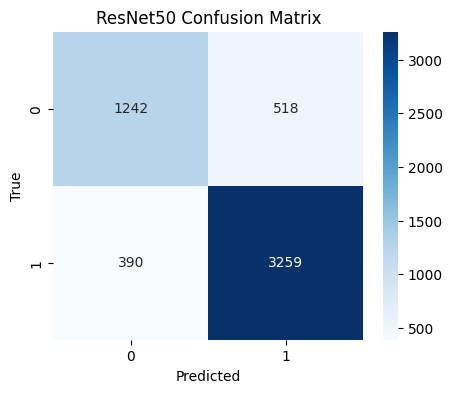

In [13]:
# Cell 13: Evaluate ResNet50
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type='cuda'):
                outputs = model(images)
                if hasattr(outputs, "logits"): outputs = outputs.logits
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy()); all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds)
    return acc, prec, rec, f1, cm, cr

acc, prec, rec, f1, cm, cr = evaluate_model(resnet_model, test_loader, device)
print("ResNet50 Test Metrics")
print(f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\nF1 Score: {f1:.4f}")
print("\nClassification Report:\n", cr)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("ResNet50 Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

torch.save(resnet_model.state_dict(), "models/resnet_checkpoint.pth")

In [14]:
# Cell 14: Train DenseNet121 with W&B
wandb.init(project="flood_detection", config={"model": "DenseNet121", "learning_rate": 1e-4, "epochs": 50, "batch_size": 32, "patience": 2, "early_stop_threshold": 0.001})

densenet_model = models.densenet121(pretrained=True)
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, 2)
densenet_model = densenet_model.to(device)

optimizer_dense = optim.AdamW(densenet_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

num_epochs, patience, early_stop_threshold = 50, 2, 0.001
best_val_loss, epochs_no_improve = float('inf'), 0
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(densenet_model, train_loader, optimizer_dense, criterion, device)
    val_loss, val_acc = validate_epoch(densenet_model, val_loader, criterion, device)
    
    train_losses.append(train_loss); train_accuracies.append(train_acc)
    val_losses.append(val_loss); val_accuracies.append(val_acc)
    
    wandb.log({"epoch": epoch+1, "train_loss": train_loss, "train_accuracy": train_acc, "val_loss": val_loss, "val_accuracy": val_acc})
    
    print(f"DenseNet121 - Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    if val_loss < early_stop_threshold: 
        print("Low validation loss; stopping early."); break
    if val_loss < best_val_loss:
        best_val_loss = val_loss; epochs_no_improve = 0
        torch.save(densenet_model.state_dict(), "models/densenet_best.pth")
        wandb.save("models/densenet_best.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience: 
            print(f"No improvement for {patience} epochs; stopping."); break

wandb.finish()

/home/nhotin/anaconda3/envs/as/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nhotin/anaconda3/envs/as/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.ui

DenseNet121 - Epoch 1/50
Train Loss: 0.4529 | Train Acc: 0.7558
Val Loss: 0.4074 | Val Acc: 0.7779


/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

DenseNet121 - Epoch 2/50
Train Loss: 0.3594 | Train Acc: 0.8104
Val Loss: 0.3468 | Val Acc: 0.8225


/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

DenseNet121 - Epoch 3/50
Train Loss: 0.2959 | Train Acc: 0.8449
Val Loss: 0.3413 | Val Acc: 0.8243


/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

DenseNet121 - Epoch 4/50
Train Loss: 0.2489 | Train Acc: 0.8701
Val Loss: 0.3173 | Val Acc: 0.8354


/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

DenseNet121 - Epoch 5/50
Train Loss: 0.2053 | Train Acc: 0.8930
Val Loss: 0.4495 | Val Acc: 0.8167


/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

DenseNet121 - Epoch 6/50
Train Loss: 0.1798 | Train Acc: 0.9093
Val Loss: 0.3778 | Val Acc: 0.8352
No improvement for 2 epochs; stopping.


/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

DenseNet121 Test Metrics
Accuracy: 0.8456
Precision: 0.8441
Recall: 0.8456
F1 Score: 0.8446

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.74      0.76      1760
           1       0.88      0.90      0.89      3649

    accuracy                           0.85      5409
   macro avg       0.83      0.82      0.82      5409
weighted avg       0.84      0.85      0.84      5409



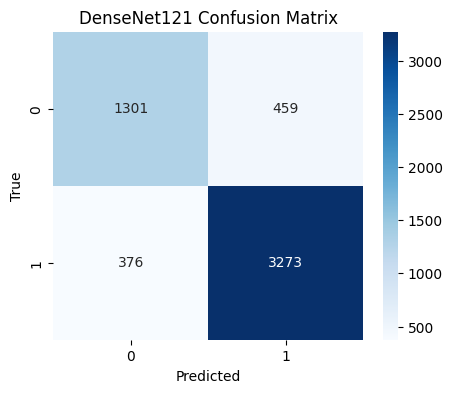

In [15]:
# Cell 15: Evaluate DenseNet121
acc, prec, rec, f1, cm, cr = evaluate_model(densenet_model, test_loader, device)
print("DenseNet121 Test Metrics")
print(f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\nF1 Score: {f1:.4f}")
print("\nClassification Report:\n", cr)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("DenseNet121 Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

torch.save(densenet_model.state_dict(), "models/densenet_checkpoint.pth")

In [16]:
# Cell 16: Train EfficientNetB0 with W&B
wandb.init(project="flood_detection", config={"model": "EfficientNetB0", "learning_rate": 1e-4, "epochs": 50, "batch_size": 32, "patience": 2, "early_stop_threshold": 0.001})

efficientnet_model = timm.create_model('efficientnet_b0', pretrained=True)
efficientnet_model.classifier = nn.Linear(efficientnet_model.get_classifier().in_features, 2)
efficientnet_model = efficientnet_model.to(device)

optimizer_eff = optim.AdamW(efficientnet_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

num_epochs, patience, early_stop_threshold = 50, 2, 0.001
best_val_loss, epochs_no_improve = float('inf'), 0
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(efficientnet_model, train_loader, optimizer_eff, criterion, device)
    val_loss, val_acc = validate_epoch(efficientnet_model, val_loader, criterion, device)
    
    train_losses.append(train_loss); train_accuracies.append(train_acc)
    val_losses.append(val_loss); val_accuracies.append(val_acc)
    
    wandb.log({"epoch": epoch+1, "train_loss": train_loss, "train_accuracy": train_acc, "val_loss": val_loss, "val_accuracy": val_acc})
    
    print(f"EfficientNetB0 - Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    if val_loss < early_stop_threshold: 
        print("Low validation loss; stopping early."); break
    if val_loss < best_val_loss:
        best_val_loss = val_loss; epochs_no_improve = 0
        torch.save(efficientnet_model.state_dict(), "models/efficientnet_best.pth")
        wandb.save("models/efficientnet_best.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience: 
            print(f"No improvement for {patience} epochs; stopping."); break

wandb.finish()

/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

EfficientNetB0 - Epoch 1/50
Train Loss: 0.4591 | Train Acc: 0.7453
Val Loss: 0.4277 | Val Acc: 0.7562


/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

EfficientNetB0 - Epoch 2/50
Train Loss: 0.3562 | Train Acc: 0.8109
Val Loss: 0.3629 | Val Acc: 0.8053


/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

EfficientNetB0 - Epoch 3/50
Train Loss: 0.2839 | Train Acc: 0.8513
Val Loss: 0.3438 | Val Acc: 0.8204


/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

EfficientNetB0 - Epoch 4/50
Train Loss: 0.2166 | Train Acc: 0.8923
Val Loss: 0.3659 | Val Acc: 0.8232


/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

EfficientNetB0 - Epoch 5/50
Train Loss: 0.1711 | Train Acc: 0.9148
Val Loss: 0.4433 | Val Acc: 0.8064
No improvement for 2 epochs; stopping.


/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

EfficientNetB0 Test Metrics
Accuracy: 0.8116
Precision: 0.8107
Recall: 0.8116
F1 Score: 0.8111

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.70      0.71      1760
           1       0.86      0.86      0.86      3649

    accuracy                           0.81      5409
   macro avg       0.79      0.78      0.78      5409
weighted avg       0.81      0.81      0.81      5409



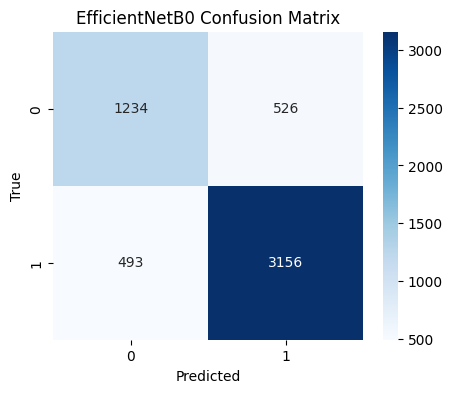

In [17]:
# Cell 17: Evaluate EfficientNetB0
acc, prec, rec, f1, cm, cr = evaluate_model(efficientnet_model, test_loader, device)
print("EfficientNetB0 Test Metrics")
print(f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\nF1 Score: {f1:.4f}")
print("\nClassification Report:\n", cr)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("EfficientNetB0 Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

torch.save(efficientnet_model.state_dict(), "models/efficientnet_checkpoint.pth")

In [28]:
# Cell 18: Train ViT with W&B
wandb.init(project="flood_detection", config={"model": "ViT", "learning_rate": 5e-5, "epochs": 50, "batch_size": 32, "patience": 2, "early_stop_threshold": 0.001})

vit_model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=2)
vit_model = vit_model.to(device)

optimizer_vit = optim.AdamW(vit_model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

num_epochs, patience, early_stop_threshold = 50, 2, 0.001
best_val_loss, epochs_no_improve = float('inf'), 0
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(vit_model, train_loader, optimizer_vit, criterion, device)
    val_loss, val_acc = validate_epoch(vit_model, val_loader, criterion, device)
    
    train_losses.append(train_loss); train_accuracies.append(train_acc)
    val_losses.append(val_loss); val_accuracies.append(val_acc)
    
    wandb.log({"epoch": epoch+1, "train_loss": train_loss, "train_accuracy": train_acc, "val_loss": val_loss, "val_accuracy": val_acc})
    
    print(f"ViT - Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    if val_loss < early_stop_threshold: 
        print("Low validation loss; stopping early."); break
    if val_loss < best_val_loss:
        best_val_loss = val_loss; epochs_no_improve = 0
        torch.save(vit_model.state_dict(), "models/vit_best.pth")
        wandb.save("models/vit_best.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience: 
            print(f"No improvement for {patience} epochs; stopping."); break

wandb.finish()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/

ViT - Epoch 1/50
Train Loss: 0.4795 | Train Acc: 0.7337
Val Loss: 0.4101 | Val Acc: 0.7812


/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

ViT - Epoch 2/50
Train Loss: 0.3779 | Train Acc: 0.7981
Val Loss: 0.3709 | Val Acc: 0.8023


/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

ViT - Epoch 3/50
Train Loss: 0.2959 | Train Acc: 0.8447
Val Loss: 0.3592 | Val Acc: 0.8119


/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

ViT - Epoch 4/50
Train Loss: 0.2288 | Train Acc: 0.8798
Val Loss: 0.4217 | Val Acc: 0.8034


/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

ViT - Epoch 5/50
Train Loss: 0.1873 | Train Acc: 0.9050
Val Loss: 0.4651 | Val Acc: 0.8097
No improvement for 2 epochs; stopping.


/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

ViT Test Metrics
Accuracy: 0.8005
Precision: 0.8132
Recall: 0.8005
F1 Score: 0.8042

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.78      0.72      1760
           1       0.88      0.81      0.85      3649

    accuracy                           0.80      5409
   macro avg       0.77      0.80      0.78      5409
weighted avg       0.81      0.80      0.80      5409



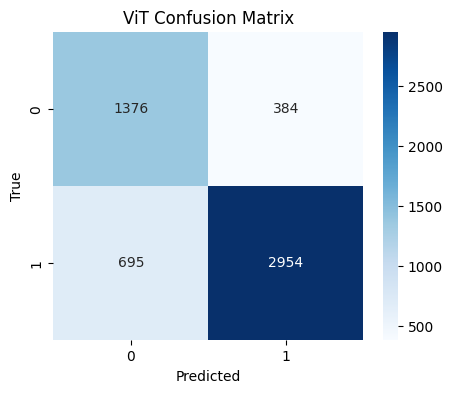

In [29]:
# Cell 19: Evaluate ViT
acc, prec, rec, f1, cm, cr = evaluate_model(vit_model, test_loader, device)
print("ViT Test Metrics")
print(f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\nF1 Score: {f1:.4f}")
print("\nClassification Report:\n", cr)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("ViT Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

torch.save(vit_model.state_dict(), "models/vit_checkpoint.pth")

In [30]:
# Cell 20: Hard and Soft Voting Ensemble
def get_hard_predictions(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            with autocast(device_type='cuda'):
                outputs = model(images)
                if hasattr(outputs, "logits"): outputs = outputs.logits
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions

def get_probabilities(model, dataloader):
    model.eval()
    probabilities = []
    softmax = nn.Softmax(dim=1)
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            with autocast(device_type='cuda'):
                outputs = model(images)
                if hasattr(outputs, "logits"): outputs = outputs.logits
            probs = softmax(outputs)
            probabilities.extend(probs.cpu().numpy())
    return np.array(probabilities)

resnet_preds = get_hard_predictions(resnet_model, test_loader)
densenet_preds = get_hard_predictions(densenet_model, test_loader)
eff_preds = get_hard_predictions(efficientnet_model, test_loader)
vit_preds = get_hard_predictions(vit_model, test_loader)

resnet_probs = get_probabilities(resnet_model, test_loader)
densenet_probs = get_probabilities(densenet_model, test_loader)
eff_probs = get_probabilities(efficientnet_model, test_loader)
vit_probs = get_probabilities(vit_model, test_loader)

ensemble_hard_preds = [max(set([r, d, e, v]), key=[r, d, e, v].count) for r, d, e, v in zip(resnet_preds, densenet_preds, eff_preds, vit_preds)]
ensemble_probs = (resnet_probs + densenet_probs + eff_probs + vit_probs) / 4.0
ensemble_soft_preds = np.argmax(ensemble_probs, axis=1)

true_labels = [labels.cpu().numpy() for _, labels in test_loader]
true_labels = np.concatenate(true_labels)

/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
/tmp/ipykernel_1492769/47319523.py:10: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np

Hard Voting Ensemble Metrics:
Accuracy: 0.8471
Precision: 0.8505
Recall: 0.8471
F1 Score: 0.8484

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.80      0.77      1760
           1       0.90      0.87      0.88      3649

    accuracy                           0.85      5409
   macro avg       0.82      0.83      0.83      5409
weighted avg       0.85      0.85      0.85      5409



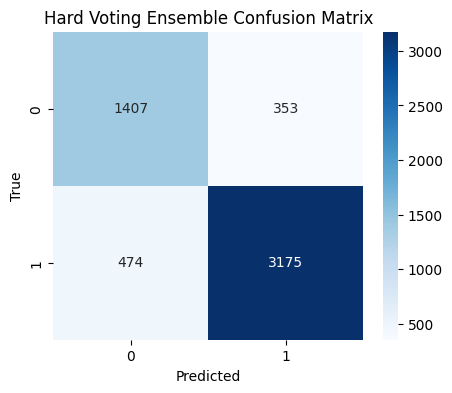

Soft Voting Ensemble Metrics:
Accuracy: 0.8560
Precision: 0.8541
Recall: 0.8560
F1 Score: 0.8545

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.74      0.77      1760
           1       0.88      0.91      0.90      3649

    accuracy                           0.86      5409
   macro avg       0.84      0.83      0.83      5409
weighted avg       0.85      0.86      0.85      5409



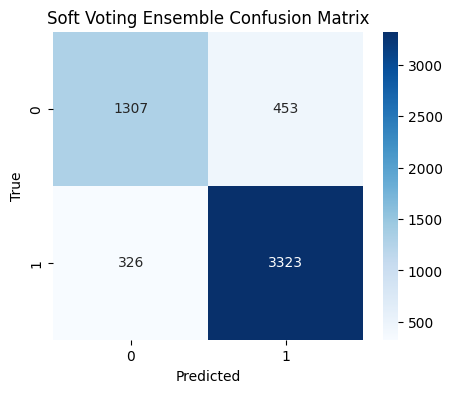

In [33]:
# Cell 21: Evaluate Hard and Soft Voting Ensemble
def evaluate_predictions(true_labels, preds, ensemble_name):
    acc = accuracy_score(true_labels, preds)
    prec = precision_score(true_labels, preds, average='weighted')
    rec = recall_score(true_labels, preds, average='weighted')
    f1 = f1_score(true_labels, preds, average='weighted')
    cm = confusion_matrix(true_labels, preds)
    cr = classification_report(true_labels, preds)
    print(f"{ensemble_name} Metrics:")
    print(f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\nF1 Score: {f1:.4f}")
    print("\nClassification Report:\n", cr)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{ensemble_name} Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()
    return {"Model": ensemble_name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1 Score": f1}

results = [
    evaluate_model(resnet_model, test_loader, device)[0:4],
    evaluate_model(densenet_model, test_loader, device)[0:4],
    evaluate_model(efficientnet_model, test_loader, device)[0:4],
    evaluate_model(vit_model, test_loader, device)[0:4]
]
# Corrected list comprehension to unpack 4 values
results = [{"Model": m, "Accuracy": a, "Precision": p, "Recall": r, "F1 Score": f} for m, (a, p, r, f) in zip(["ResNet50", "DenseNet121", "EfficientNetB0", "ViT"], results)]
results.append(evaluate_predictions(true_labels, ensemble_hard_preds, "Hard Voting Ensemble"))
results.append(evaluate_predictions(true_labels, ensemble_soft_preds, "Soft Voting Ensemble"))

                      Accuracy  Precision    Recall  F1 Score
Model                                                        
ResNet50              0.832132   0.829722  0.832132  0.830411
DenseNet121           0.845628   0.844074  0.845628  0.844632
EfficientNetB0        0.811610   0.810740  0.811610  0.811143
ViT                   0.800518   0.813198  0.800518  0.804175
Hard Voting Ensemble  0.847107   0.850506  0.847107  0.848358
Soft Voting Ensemble  0.855981   0.854110  0.855981  0.854517


<Figure size 1000x600 with 0 Axes>

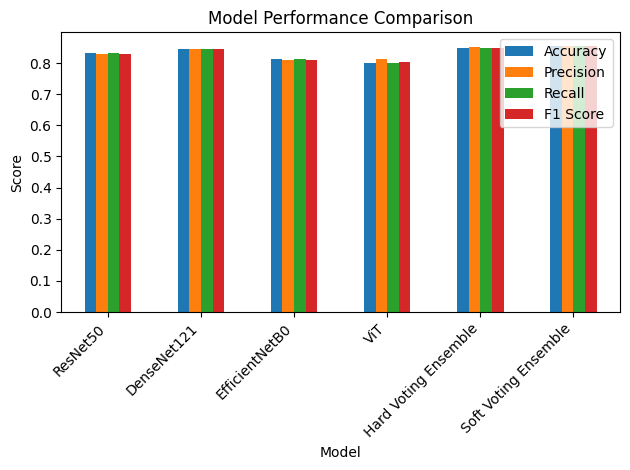

In [34]:
# Cell 22: Display model performance comparison
df = pd.DataFrame(results).set_index("Model")
print(df.to_string())

plt.figure(figsize=(10, 6))
df[["Accuracy", "Precision", "Recall", "F1 Score"]].plot(kind='bar')
plt.title("Model Performance Comparison")
plt.ylabel("Score"); plt.xlabel("Model")
plt.xticks(rotation=45, ha='right'); plt.legend(); plt.tight_layout()
plt.show()